# Gini Coefficient Across the United States #
Zohaib Anwar N10143738

My plan is to look at inequality across the U.S., specifically at the state level. I want to firstly,
deduce which states have higher or lower inequality (as measured by the Gini index). Thereafter I want to
determine what is driving the inequality across states, such as differing levels of education.
I will use a variable for income earned in the past 12 months (wagp) as answered by
each respondent of the data set described below, to construct a Gini coefficient by state (the state in which the individual resides is another variable st), and for the entire U.S. Then I will compare the results between states and the entire
U.S. The other variables analyzed are age, nationality, years of schooling, sex, race, number of Hispanics, and whether the individuals work in STEM related fields. I will also check correlations between other variables and the Gini coefficient to determine whether they are affecting which states have higher or lower inequality. After doing this I hope to be better able to explain inequality across the U.S., which states have more/less of it, and why. 

# Data #


In this project I will use the [Public Use Microdata Sample](https://www.census.gov/programs-surveys/acs/data/pums.html), which contains data from the [American
Community Survey](https://www.census.gov/programs-surveys/acs/), from the years 2011-2015. This data source has information on both personal and
household levels of individuals across the U.S. The data is released yearly, and contains information on
about millions of individuals (about 295,000 individuals are surveyed monthly). I will use the individual
records. The data itself is responses to several survey questions given by these individuals. It contains
several variables. I will use wagp, or the variable for income earned in the past 12 months as answered by
each respondent, to construct a Gini coefficient by state (the state in which the individual resides is
another variable st), and for the entire U.S. Then I will compare the results between states and the entire
U.S. I will also check correlations between other variables and the Gini coefficient to determine whether
they are affecting which states have higher or lower inequality. I will look at years of schooling, property
tax, age, and the number of minorities and immigrants.

Below is the code I have used to access the data. Most of the columns from the data set are not needed for this analysis, hence I have specified some of the specific columns I am interested in and removed the rest of them. 



In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import zipfile as zf
import numpy as np
import requests, io 
import shutil
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"
import html5lib
import plotly 
from plotly.offline import iplot, iplot_mpl 
import plotly.graph_objs as go
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)
from bs4 import BeautifulSoup
import statsmodels.api as sm

In [2]:
url= "https://www2.census.gov/programs-surveys/acs/data/pums/2015/5-Year/csv_pus.zip"
r=requests.get(url,timeout=1)                                                    #requesting the zipfile from the website

In [3]:
mlz = zf.ZipFile(io.BytesIO(r.content)) 
mlz.namelist()


['ss15pusa.csv',
 'ss15pusb.csv',
 'ss15pusc.csv',
 'ss15pusd.csv',
 'ACS2011_2015_PUMS_README.pdf']

In [4]:
cols=['ADJINC','PUMA00','ST','AGEP','CIT','ENG','MAR','MIL','SCHL','SEX','WAGP','HISP','NATIVITY','PINCP','RAC1P','SCIENGRLP']
na=['b','bb','bbb','bbbb','bbbbb','bbbbb','bbbbbb','bbbbbbb','bbbbbbbb']
url1='https://gist.githubusercontent.com/JeffPaine/3083347/'
url2='raw/7460b8beb99f717efb87c6e388903852fc52caf9/us_state_abbreviations.py'
r=requests.get(url1+url2) 
exec(BeautifulSoup(r.content,'lxml').get_text())  
                                                  
#Creating a list of states in a variable conveniently named State by scraping
#a ready-made list from github.  


In [5]:
PUMS1=pd.read_csv(mlz.open(mlz.namelist()[0]),usecols=cols,na_values=na)
PUMS2=pd.read_csv(mlz.open(mlz.namelist()[1]),usecols=cols,na_values=na)
PUMS3=pd.read_csv(mlz.open(mlz.namelist()[2]),usecols=cols,na_values=na)
PUMS4=pd.read_csv(mlz.open(mlz.namelist()[3]),usecols=cols,na_values=na)         #Saving the seperate csv files into variables

In [6]:
PUMS=pd.concat([PUMS1,PUMS2,PUMS3,PUMS4])                         #Combining the files and renaming the columns and indices
PUMS['ADJINC']=PUMS['ADJINC'].map({1073094:2011,1042852:2012,1025215:2013,1009585:2014,1001264:2015})
PUMS['ST']=PUMS['ST'].map({1:"AL", 2:"AK", 4:"AZ", 5:"AR", 6:"CA", 8:"CO", 9:"CT",11:"DC" ,10:"DE", 12:"FL", 13:"GA", 
          15:"HI", 16:"ID", 17:"IL", 18:"IN", 19:"IA", 20:"KS", 21:"KY", 22:"LA", 23:"ME", 24:"MD", 
          25:"MA", 26:"MI", 27:"MN", 28:"MS", 29:"MO", 30:"MT", 31:"NE", 32:"NV", 33:"NH", 34:"NJ", 
          35:"NM", 36:"NY", 37:"NC", 38:"ND", 39:"OH", 40:"OK", 41:"OR", 42:"PA", 44:"RI", 45:"SC", 
          46:"SD", 47:"TN", 48:"TX", 49:"UT", 50:"VT", 51:"VA", 53:"WA", 54:"WV", 55:"WI", 56:"WY",72:"PR"})



In [7]:
#Creating a new dataframe with the required index and states
Gini=pd.DataFrame([x for x in list(range(2011,2016)) for _ in range(52)],
                  columns=['Year']).merge(pd.DataFrame((['US']+([x for x in states]))*5,columns=['State']),
                                          left_index=True,right_index=True).set_index(['Year','State'])
#Calculating Gini coefficient for entire U.S. and by state, by finding 
#the area under the Lorenz curve and the line of equality.
Gini['Gini']=np.nan
def Gini_calculation(year,st=None):
    if st==None:
        Gini1=PUMS[(PUMS['ADJINC']==year) & (PUMS['WAGP']>0)].sort_values('WAGP')
        Gini1['Equality']=np.linspace(0.0,1.0,len(Gini1['WAGP']))
        Gini1['%']=Gini1['WAGP']/sum(Gini1['WAGP'])
        Gini1['cumulative']=np.cumsum(Gini1['%'])
        area_perf=np.trapz(Gini1['Equality'],Gini1['Equality'])
        area_lorenz=np.trapz(Gini1['cumulative'],Gini1['Equality'])
        Gini_US=(area_perf-area_lorenz)/area_perf
        Gini.loc[(year,'US'),'Gini']=Gini_US
    else:
        Gini1=PUMS[(PUMS['ADJINC']==year) & (PUMS['ST']==st) & (PUMS['WAGP']>0)].sort_values('WAGP')
        Gini1['Equality']=np.linspace(0.0,1.0,len(Gini1['WAGP']))
        Gini1['%']=Gini1['WAGP']/sum(Gini1['WAGP'])
        Gini1['cumulative']=np.cumsum(Gini1['%'])
        area_perf=np.trapz(Gini1['Equality'],Gini1['Equality'])
        area_lorenz=np.trapz(Gini1['cumulative'],Gini1['Equality'])
        Gini_ST=(area_perf-area_lorenz)/area_perf
        Gini.loc[(year,st),'Gini']=Gini_ST

for x in list(range(2011,2016)):
    Gini_calculation(x)
    for y in states:
        Gini_calculation(x,st=y)
    
    

In [8]:
#Creating a Quartile and Scale variable to determine whether the 
#Gini coefficient is below, above or equal to the
#coefficient of the U.S. for that year.
Gini['Scale']=np.NaN
Gini['Scale']=Gini['Scale'].astype(object)
def Gini_Scale(x):
    for g,i in enumerate(Gini.loc[x]['Gini']):
        a=Gini.loc[x].index[g]
        if i>Gini.loc[(x,'US'),'Gini']:
            Gini.loc[(x,a),'Scale':'Scale']='Larger'
        elif i<Gini.loc[(x,'US'),'Gini']:
            Gini.loc[(x,a),'Scale':'Scale']='Smaller'
        elif i==Gini.loc[(x,'US'),'Gini']:
            Gini.loc[(x,a),'Scale':'Scale']='Equal'
for year in list(range(2011,2016)):
    Gini_Scale(year)
        

In [9]:
#Mapping the Gini Coefficient for the latest year of data to get 
#a sense of the spread.
data = [ dict(
        type='choropleth',
        locations = states,
        z =Gini.xs(2015,level=0)['Gini'].drop('US'),
        locationmode = 'USA-states',
        text = Gini.xs(2012,level=0)['Gini'].drop('US'),
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Gini Coefficient")
        ) ]

layout = dict(
        title = 'Gini Coefficient<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = False,
            lakecolor = 'rgb(255, 255, 255)'),
             )
iplot(go.Figure(data=data, layout=layout), link_text="")

Here it is interesting to note that most of the states, in 2015, with higher Gini coefficients are those along the coast such as California, Texas, New York and New Jersey. It is also obvious that not many states have relatively large or lower Gini coefficients, in fact only a few seem to stand out. I will explore this more below.

In [10]:
#Here I create columns for each of the relevant variables
#and a function that calculates the proportion of
#Minority, Immigrants, Hispanic, people in STEM related fields,
#as well as average schooling and age for each state and year,
#well as for the U.S.as
PEd=PUMS.set_index(['ADJINC','ST']).sort_index(level='ST') 
Gini['P_Sex']=np.nan                                        
Gini['P_Min']=np.nan                                       
Gini['P_Im']=np.nan                                        
Gini['P_Hisp']=np.nan                                      
Gini['Stem']=np.nan                                        
Gini['Age']=np.nan
Gini['Schooling']=np.nan
def Proportion_Calc(x,y=None):
    if y==None:
        Gini.loc[(x,'US'),'P_Sex']=100*PEd.loc[x]['SEX'][PEd.loc[x]['SEX']==2].count()/PEd.\
        loc[x].shape[0]
        Gini.loc[(x,'US'),'P_Min']=100*PEd.loc[x]['RAC1P'][PEd.loc[x]['RAC1P'].isin([2,3,4,5,7])].count()/PEd.\
        loc[x].shape[0]
        Gini.loc[(x,'US'),'P_Im']=100*PEd.loc[x]['NATIVITY'][PEd.loc[x]['NATIVITY']==2].count()/PEd.loc[x]. \
        shape[0]
        Gini.loc[(x,'US'),'P_Hisp']=100*PEd.loc[x]['HISP'][PEd.loc[x]['HISP']>1].count()/PEd.loc[x]. \
        shape[0]
        Gini.loc[(x,'US'),'Stem']=100*PEd.loc[x]['SCIENGRLP'][PEd.loc[x]['SCIENGRLP']==1].count()/PEd.loc[x]. \
        shape[0]
        Gini.loc[(x,'US'),'Age']=PEd.loc[x]['AGEP'].mean()
        Gini.loc[(x,'US'),'Schooling']=PEd.loc[x]['SCHL'].mean()
    if y!=None:
        Gini.loc[(x,y),'P_Sex']=100*PEd.loc[x][y:y]['SEX'][PEd.loc[x][y:y]['SEX']==2].count()/PEd. \
        loc[x][y:y].shape[0]
        Gini.loc[(x,y),'P_Min']=100*PEd.loc[x][y:y]['RAC1P'][PEd.loc[x][y:y]['RAC1P'].isin([2,3,4,5,7])].count()/PEd. \
        loc[x][y:y].shape[0]
        Gini.loc[(x,y),'P_Im']=100*PEd.loc[x][y:y]['NATIVITY'][PEd.loc[x][y:y]['NATIVITY']==2].count()/PEd.loc[x][y:y]. \
        shape[0]
        Gini.loc[(x,y),'P_Hisp']=100*PEd.loc[x][y:y]['HISP'][PEd.loc[x][y:y]['HISP']>1].count()/PEd.loc[x][y:y]. \
        shape[0]
        Gini.loc[(x,y),'Stem']=100*PEd.loc[x][y:y]['SCIENGRLP'][PEd.loc[x][y:y]['SCIENGRLP']==1].count()/PEd.loc[x][y:y]. \
        shape[0]
        Gini.loc[(x,y),'Age']=PEd.loc[x][y:y]['AGEP'].mean()
        Gini.loc[(x,y),'Schooling']=PEd.loc[x][y:y]['SCHL'].mean()

In [11]:
for year in list(range(2011,2016)):
    Proportion_Calc(year)
    for st in states:
        Proportion_Calc(year,y=st)


In [13]:
#Creating sorted variables to determine which states have higher
#values for each variable
def Sorted(z):
    for year in list(range(2011,2016)):
        globals()['{}_{}'.format(z,year)]=Gini.loc[year].sort_values('{}'.format(z),ascending=False)
        globals()['{}_{}'.format(z,year)]['Scale']=np.nan
        for g,i in enumerate(globals()['{}_{}'.format(z,year)]['{}'.format(z)]):
            a=globals()['{}_{}'.format(z,year)].index[g]
            if i>globals()['{}_{}'.format(z,year)].loc['US','{}'.format(z)]:
                globals()['{}_{}'.format(z,year)].loc[a,'Scale':'Scale']='Larger'
            elif i<globals()['{}_{}'.format(z,year)].loc['US','{}'.format(z)]:
                globals()['{}_{}'.format(z,year)].loc[a,'Scale':'Scale']='Smaller'
            elif i==globals()['{}_{}'.format(z,year)].loc['US','{}'.format(z)]:
                globals()['{}_{}'.format(z,year)].loc[a,'Scale':'Scale']='Equal'
    globals()['All_{}'.format(z)]=[]
    for year in list(range(2011,2016)):
        globals()['Order_{}_{}'.format(z,year)]=pd.DataFrame()
        globals()['Order_{}_{}'.format(z,year)]['Scale']=globals()['{}_{}'.format(z,year)]['Scale'].drop('US')
        globals()['All_{}'.format(z)].append(globals()['Order_{}_{}'.format(z,year)])
    globals()['C_{}'.format(z)]=pd.DataFrame()
    globals()['D_{}'.format(z)]=pd.DataFrame()
    globals()['E_{}'.format(z)]=pd.DataFrame()
    globals()['F_{}'.format(z)]=pd.DataFrame()
    for value in globals()['All_{}'.format(z)]:
        globals()['C_{}'.format(z)]=pd.concat([globals()['C_{}'.format(z)],pd.Series(value[value['Scale']=='Larger'].index.values).head(5).reset_index(drop=True)],axis=1,ignore_index=True)
        globals()['D_{}'.format(z)]=pd.concat([globals()['D_{}'.format(z)],pd.Series(value[value['Scale']=='Smaller'].index.values).tail(5).reset_index(drop=True)],axis=1,ignore_index=True)
        globals()['E_{}'.format(z)]=pd.concat([globals()['E_{}'.format(z)],pd.Series(value[value['Scale']=='Larger'].index.values)],axis=1,ignore_index=True)
        globals()['F_{}'.format(z)]=pd.concat([globals()['F_{}'.format(z)],pd.Series(value[value['Scale']=='Smaller'].index.values)],axis=1,ignore_index=True)

In [14]:
Sorted('Gini')
Sorted('P_Sex')
Sorted('P_Min')
Sorted('P_Im')
Sorted('P_Hisp')
Sorted('Stem')
Sorted('Age')
Sorted('Schooling')

In [15]:
#Creating tables to display states that have both a higher Gini coefficient
#and higher values for each of the variables of interest
Upper=pd.DataFrame('State: ',columns=list(range(2011,2016)),index=['Fem','Min','Hisp','Imm','Stem','Age','Schooling'])
for i in C_Gini.columns:
    for a in C_Gini[i]:
        if a in list(E_P_Sex[i]):
            Upper.ix['Fem':'Fem',i+2011:i+2011]=Upper.ix['Fem':'Fem',i+2011:i+2011]+' {}'.format(a)
    for a in C_Gini[i]:
        if a in list(E_P_Min[i]):
            Upper.ix['Min':'Min',i+2011:i+2011]=Upper.ix['Min':'Min',i+2011:i+2011]+' {}'.format(a)
    for a in C_Gini[i]:
        if a in list(E_P_Im[i]):
            Upper.ix['Imm':'Imm',i+2011:i+2011]=Upper.ix['Imm':'Imm',i+2011:i+2011]+' {}'.format(a)
    for a in C_Gini[i]:
        if a in list(E_P_Hisp[i]):
            Upper.ix['Hisp':'Hisp',i+2011:i+2011]=Upper.ix['Hisp':'Hisp',i+2011:i+2011]+' {}'.format(a)
    for a in C_Gini[i]:
        if a in list(E_Schooling[i]):
            Upper.ix['Schooling':'Schooling',i+2011:i+2011]=Upper.ix['Schooling':'Schooling',i+2011:i+2011]+' {}'.format(a)
    for a in C_Gini[i]:
        if a in list(E_Stem[i]):
            Upper.ix['Stem':'Stem',i+2011:i+2011]=Upper.ix['Stem':'Stem',i+2011:i+2011]+' {}'.format(a)
    for a in C_Gini[i]:
        if a in list(E_Age[i]):
            Upper.ix['Age':'Age',i+2011:i+2011]=Upper.ix['Age':'Age',i+2011:i+2011]+' {}'.format(a)
Lower=pd.DataFrame('State: ',columns=list(range(2011,2016)),index=['Fem','Min','Hisp','Imm','Stem','Age','Schooling'])
for i in D_Gini.columns:
    for a in D_Gini[i]:
        if a in list(F_P_Sex[i]):
            Lower.ix['Fem':'Fem',i+2011:i+2011]=Lower.ix['Fem':'Fem',i+2011:i+2011]+' {}'.format(a)
    for a in D_Gini[i]:
        if a in list(F_P_Min[i]):
            Lower.ix['Min':'Min',i+2011:i+2011]=Lower.ix['Min':'Min',i+2011:i+2011]+' {}'.format(a)
    for a in D_Gini[i]:
        if a in list(F_P_Im[i]):
            Lower.ix['Imm':'Imm',i+2011:i+2011]=Lower.ix['Imm':'Imm',i+2011:i+2011]+' {}'.format(a)
    for a in D_Gini[i]:
        if a in list(F_P_Hisp[i]):
            Lower.ix['Hisp':'Hisp',i+2011:i+2011]=Lower.ix['Hisp':'Hisp',i+2011:i+2011]+' {}'.format(a)
    for a in D_Gini[i]:
        if a in list(F_Schooling[i]):
            Lower.ix['Schooling':'Schooling',i+2011:i+2011]=Lower.ix['Schooling':'Schooling',i+2011:i+2011]+' {}'.format(a)
    for a in D_Gini[i]:
        if a in list(F_Stem[i]):
            Lower.ix['Stem':'Stem',i+2011:i+2011]=Lower.ix['Stem':'Stem',i+2011:i+2011]+' {}'.format(a)
    for a in D_Gini[i]:
        if a in list(F_Age[i]):
            Lower.ix['Age':'Age',i+2011:i+2011]=Lower.ix['Age':'Age',i+2011:i+2011]+' {}'.format(a)

In [16]:
Upper


,2011,2012,2013,2014,2015
Fem,State: CT NY MA,State: CT MA NY DC,State: CT NY DC MA,State: CT NY MA NJ,State: CT MA NY
Min,State: NY,State: NY DC,State: NY DC,State: NY NJ,State: NY
Hisp,State: CA,State: CA,State: CA,State: CA NJ,State: CA
Imm,State: CT NY CA MA,State: CT MA CA NY DC,State: CT NY CA DC MA,State: CT NY MA CA NJ,State: CT MA NY CA
Stem,State: CT NY MA,State: CT MA NY,State: CT NY MA,State: CT NY MA NJ,State: CT MA NY UT
Age,State: CT NY MA,State: CT MA NY,State: CT NY MA,State: CT NY MA NJ,State: CT MA NY
Schooling,State: CT NY MA,State: CT MA NY DC,State: CT NY DC MA,State: CT NY MA NJ,State: CT MA NY


Here I have displayed the states the states with the highest Gini Coefficient (top 5), and whether or not they also have higher proportions and averages for each of the variables than the United States. As it can be seen most of the variables have somewhere from 2-5 states that also have higher values than the 
United States. This implies that most of the variables, proportion female, minority, hispanic, immigrant, people with a degree in a STEM related field, 
average age and schooling all may have a positive effect on inequality. This is is as expected for most of the variables as one would expect number of females, minority, hispanic, immigrants and those in a STEM field to increase inequality in a state, as well as states with higher average age. Average schooling on the other hand, I would expect to negatively affect inequality, since a higher level of schooling implies that more people are educated, but it could also imply that there are more skilled versus unskilled workers in the state leading to higher inequality.

In [17]:
Lower

,2011,2012,2013,2014,2015
Fem,State: MT IA WY HI SD,State: NV IA WY SD HI,State: ND IA SD HI WY,State: IA WY NV SD HI,State: WI IA SD ND HI
Min,State: MT IA WY HI SD,State: NV IA WY SD,State: ND IA SD WY,State: IA WY NV SD,State: WI IA SD ND
Hisp,State: MT IA WY HI SD,State: IA WY SD HI,State: ND IA SD HI WY,State: IA WY SD HI,State: WI IA SD ND HI
Imm,State: MT IA WY SD,State: IA WY SD,State: ND IA SD WY,State: IA WY SD,State: WI IA SD ND
Stem,State: IA,State: NV IA WY HI,State: IA WY,State: IA WY NV,State: IA SD HI
Age,State: WY,State: NV WY,State: SD WY,State: WY NV SD,State: SD ND
Schooling,State: SD,State: NV SD,State: IA SD,State: NV SD,State: IA SD ND


A similar conclusion can be drawn from this table displaying states with the lowest (bottom 5) Gini coefficients, and whether or not they also have lower values than the United States for each of the variables. The results almost mirror that of the Upper table.

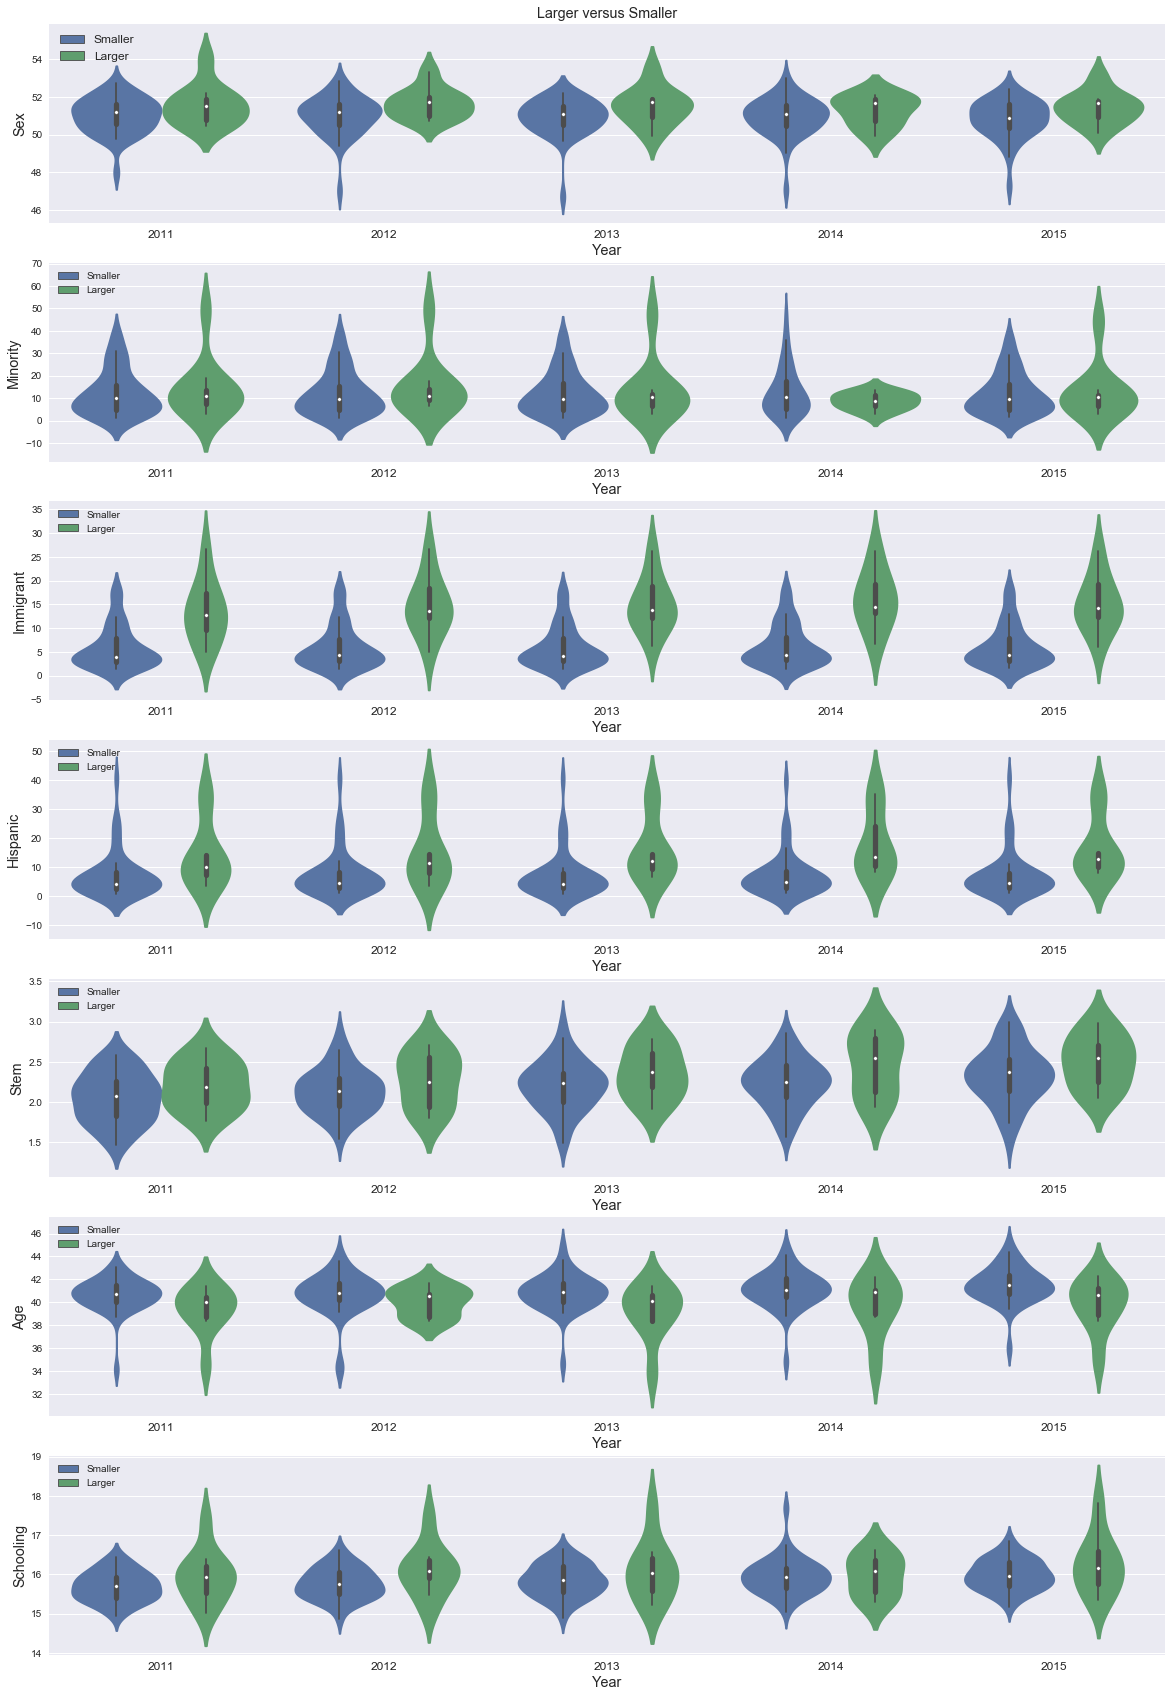

In [69]:
fig,ax= plt.subplots(7,1, figsize=(20,30))
sns.violinplot(x='Year',y='P_Sex',hue='Scale', ax=ax[0],\
               data=Gini.reset_index()[Gini.reset_index()['State']!='US']\
              )
sns.violinplot(x='Year',y='P_Min',hue='Scale', ax=ax[1],\
               data=Gini.reset_index()[Gini.reset_index()['State']!='US']\
              )
sns.violinplot(x='Year',y='P_Im',hue='Scale', ax=ax[2],\
               data=Gini.reset_index()[Gini.reset_index()['State']!='US']\
              )
sns.violinplot(x='Year',y='P_Hisp',hue='Scale', ax=ax[3],\
               data=Gini.reset_index()[Gini.reset_index()['State']!='US']\
              )
sns.violinplot(x='Year',y='Stem',hue='Scale', ax=ax[4],\
               data=Gini.reset_index()[Gini.reset_index()['State']!='US']\
              )
sns.violinplot(x='Year',y='Age',hue='Scale', ax=ax[5],\
               data=Gini.reset_index()[Gini.reset_index()['State']!='US']\
              )
sns.violinplot(x='Year',y='Schooling',hue='Scale', ax=ax[6],\
               data=Gini.reset_index()[Gini.reset_index()['State']!='US']\
              )
ax[0].set_title('Larger versus Smaller',fontsize='x-large')
ax[0].legend(loc='upper left',fontsize='large')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
ax[3].legend(loc='upper left')
ax[4].legend(loc='upper left')
ax[5].legend(loc='upper left')
ax[6].legend(loc='upper left')
ax[0].set_ylabel('Sex',fontsize='x-large')
ax[0].set_xlabel('Year',fontsize='x-large')
ax[0].tick_params('x',labelsize='large')
ax[1].set_ylabel('Minority',fontsize='x-large')
ax[1].set_xlabel('Year',fontsize='x-large')
ax[1].tick_params('x',labelsize='large')
ax[2].set_ylabel('Immigrant',fontsize='x-large')
ax[2].set_xlabel('Year',fontsize='x-large')
ax[2].tick_params('x',labelsize='large')
ax[3].set_ylabel('Hispanic',fontsize='x-large')
ax[3].set_xlabel('Year',fontsize='x-large')
ax[3].tick_params('x',labelsize='large')
ax[4].set_ylabel('Stem',fontsize='x-large')
ax[4].set_xlabel('Year',fontsize='x-large')
ax[4].tick_params('x',labelsize='large')
ax[5].set_ylabel('Age',fontsize='x-large')
ax[5].set_xlabel('Year',fontsize='x-large')
ax[5].tick_params('x',labelsize='large')
ax[6].set_ylabel('Schooling',fontsize='x-large')
ax[6].set_xlabel('Year',fontsize='x-large')
ax[6].tick_params('x',labelsize='large');

These are violin plots for each of the variables separating the data sets into a group for those states with a larger Gini Coefficient than the U.S. and those with lower. As one can see here, it seems a larger Gini coefficient is associated with a higher chance (and median) of getting a larger propotion for pretty much all of the variables except Age. Hence, higher Gini coefficient, these plots imply, is associated with a higher average schooling, a higher propotion of those with a STEM related degree, Hispanic, immigrant, minority, and female. Age it seems is saying that a higher Gini coefficient is associated with a lower average age, though this does not conceptually seem sound as more inequality should imply higher age as the older are more likely to have unequaly income, although this may say otherwise.

C:\Users\za369\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



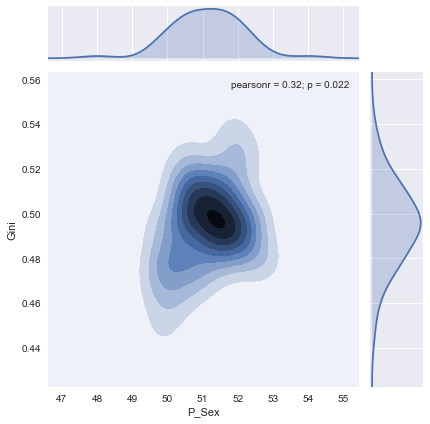

In [75]:
sns.jointplot(x='P_Sex',y='Gini',\
               data=Gini_2011.drop('US'), kind="kde");


C:\Users\za369\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



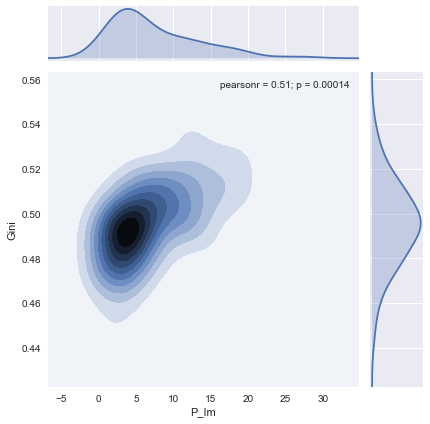

In [76]:
sns.jointplot(x='P_Im',y='Gini',\
               data=Gini_2011.drop('US'), kind="kde");

C:\Users\za369\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



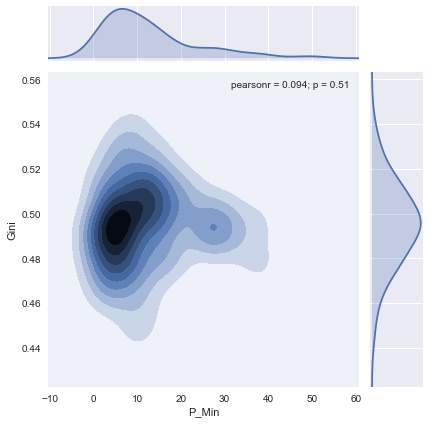

In [77]:
sns.jointplot(x='P_Min',y='Gini',\
               data=Gini_2011.drop('US'), kind="kde");

C:\Users\za369\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



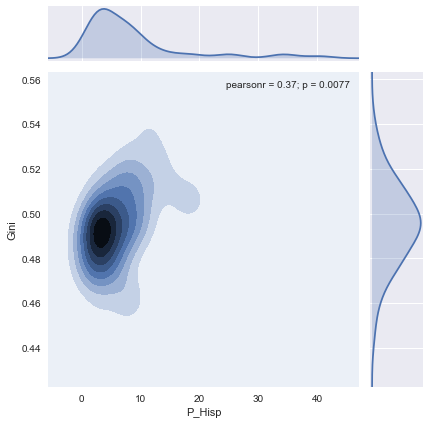

In [78]:
sns.jointplot(x='P_Hisp',y='Gini',\
               data=Gini_2011.drop('US'), kind="kde");

C:\Users\za369\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



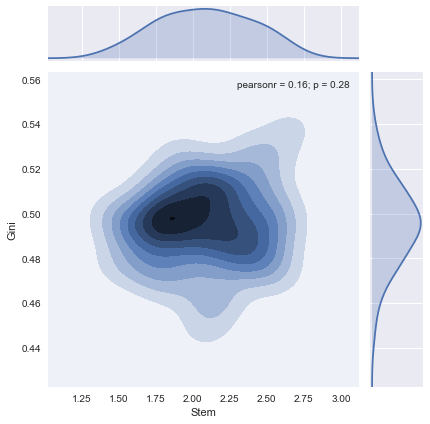

In [79]:
sns.jointplot(x='Stem',y='Gini',\
               data=Gini_2011.drop('US'), kind="kde");

C:\Users\za369\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



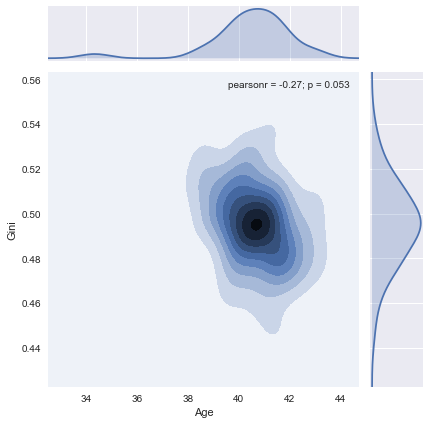

In [80]:
sns.jointplot(x='Age',y='Gini',\
               data=Gini_2011.drop('US'), kind="kde");

C:\Users\za369\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



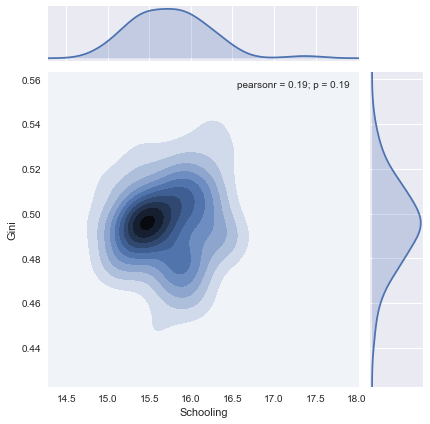

In [81]:
sns.jointplot(x='Schooling',y='Gini',\
               data=Gini_2011.drop('US'), kind="kde");

The above figures are heatmaps detailing the correlation between Gini and the variables in question. As one can see they confirm the results from before, as all of the variables have positive correlation, except agae again, which is questionable.

In [86]:
X=Gini[['P_Sex','Schooling','Age','P_Hisp','P_Min','P_Im','Stem']]
X = sm.add_constant(X)
est=sm.OLS(Gini['Gini'],X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gini   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     25.99
Date:                Fri, 12 May 2017   Prob (F-statistic):           1.18e-26
Time:                        16:51:06   Log-Likelihood:                 748.58
No. Observations:                 260   AIC:                            -1481.
Df Residuals:                     252   BIC:                            -1453.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2346      0.055      4.283      0.000         0.127     0.342
P_Sex          0.0068      0.001      6.121      0.000         0.005     0.009
Schooling      0.0012      0.003      0.422      0.673        -0.004     0.007
Age           -0.0037      0.001     -5.706      0.000        -0.005    -0.002
P_Hisp         0.0003      0.000      1.610      0.109     -5.66e-05     0.001
P_Min      -6.222e-05      0.000     -0.559      0.577        -0.000     0.000
P_Im           0.0007      0.000      2.633      0.009         0.000     0.001
Stem           0.0186      0.004      4.563      0.000         0.011     0.027
==============================================================================
Omnibus:                       25.764   Durbin-Watson:                   2.218
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.574
Skew:                          -0.691   Prob(JB):                     5.12e-08
Kurtosis:                       4.090   Cond. No.                     4.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here I provide simple regression results. The coefficients for Sex, Schooling, Age, immigration, and Stem are all significant, and also confirm our previous results. The R-Squared is .419 implying that 41.9% of the variation in the Gini Coefficient is explained by the variables

These results are questionable though as they are a simple regression on multi-level and multi-year data. What really needs to be done is a panel regression.

# Conclusion #

Through this project I have calculated the Gini coefficient across the states, and for the U.S., displayed these results in a map, observed what a higher Gini coefficiecnt means in terms of the other variables, and have provided regression results. For the most part it seems all of the variables, proportion of females in a state, minority, hispanics, and those with STEM degree as well as higher average schooling all imply higher inequality in the state, while the results show that age is associated with lower inequality. 

These results are somewhat questionable as a panel regression is not provided. Similarly, the topcoding in the PUMS dataset, especially for wage, is not accounted for. Other variables not from this data set should also be observed, as there are definitely other causes of inequality not addressed here. Furthermore, one can compare across countries, or even across smaller units of area such as Metropolitan Statistical Areas. These are all areas of further improvement.
